In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
raw_data = pd.read_excel("../sample_data_file.xlsx", sheet_name=None, header=None)
raw_data.keys()

In [ ]:
df = raw_data["Musc BL"][:]
df.head(10)

In [ ]:
def sf_ceil(x, sf=1):
    power = 10**np.floor(np.log10(abs(x)))
    power *= 10**(1-sf)
    return np.ceil(x/power)*power
        
        
def split_sheet(df):
    # DIVIDING ROW
    # Take the first row that has an empty value in the first column
    empty_row = df[df[0].isna()].index.tolist()[0]
    
    # VALID CELLS
    # Take each pair of columns that has a value in the pair-left column in the first data row
    # (so the first row after the Dividing Row)
    valid_cells = []
    for i in range(1, df.shape[1], 2):
        if  not np.isnan(df.loc[empty_row+1, i]):
            valid_cells.append(i)
    
    # CELL INFORMATION
    # The top section of the sheet contains the cell information
    df_info = df.iloc[0:empty_row]
    df_info.index = df_info[0]
    df_info = df_info.drop(columns=0)
    df_info = df_info[valid_cells].transpose()
    df_info["Date"] = pd.to_datetime(df_info["Date"]).dt.strftime("%m-%d")
    
    # CELL MEASUREMENTS
    # The bottom section of the sheet contains the cell measurements
    df_bottom = df.iloc[empty_row+1:].reset_index(drop=True)
    df_measurements = pd.DataFrame()
    for i in valid_cells:
        df_temp = df_bottom.loc[:, i:i+1]
        df_temp.columns = ["current", "frequency"]
        df_temp = df_temp.drop(index=df_temp.index[df_temp["current"].isna()])
        df_temp.insert(0, "cell", i)
        df_temp["normed_current"] = df_temp["current"] - df_temp["current"][0]
        df_temp = df_temp.drop(index=0)
        df_measurements = pd.concat([df_measurements, df_temp])
    
    return df_info, df_measurements


def bin_cells(df_measurements, norm=False, max_current=None, num_bins=100):
    if norm:
        col_name = "normed_current"
    else:
        col_name = "current"
        
    if max_current == None:
        max_current = sf_ceil(df_measurements[col_name].max(), 2)
        
    bins = np.histogram_bin_edges([], bins=num_bins, range=(0, max_current))
    df_binned = pd.DataFrame(columns=list(range(1, num_bins+1)))
    
    for cell_no, group in df_measurements.groupby("cell"):
        group["bin"] = np.digitize(group[col_name], bins)
        binned_data = {}
        for bin_num, g in group.groupby("bin"):
            binned_data[bin_num] = [g["frequency"].mean()]

        current_cell = pd.DataFrame(binned_data)
        current_cell.index=[cell_no]

        df_binned = pd.concat([df_binned, current_cell])

    df_binned = df_binned.astype(float).interpolate(method="slinear", axis=1).fillna(0)
    df_binned.columns = bins[:-1]
    
    return df_binned
    
    
def plot_heatmap(df_cells, df_sort, sort_key=None, norm=False, num_bins=100, max_current=None, x_axis_ticks=10,
                 plot_title=None, xlabel=None, ylabel=None):
    if norm:
        col_name = "normed_current"
    else:
        col_name = "current"
        
    if max_current == None:
        max_current = sf_ceil(df_cells[col_name].max())
    
    binned_cells = bin_cells(df_cells, norm=norm, num_bins=num_bins, max_current=max_current)
    
    if sort_key != None:
        order = df_sort.sort_values(sort_key, axis=1).columns
    else:
        order = binned_cells.index
    
    hm = sns.heatmap(binned_cells.loc[order])
    
    ticks = list(range(0, num_bins, int(num_bins/x_axis_ticks)))
    labels = [int(x*max_current/num_bins) for x in ticks]
    
    hm.set_xticks(ticks, labels)
    hm.set_yticks([])
    
    if plot_title:
        hm.set_title(plot_title)
    
    if xlabel:
        hm.set_xlabel(xlabel)
    else:
        if norm:
            hm.set_xlabel("Normalised Current")
        else:
            hm.set_xlabel("Current")
            
    if ylabel:
        hm.set_ylabel(ylabel)
    else:
        hm.set_ylabel(f"Cell (sorted by '{sort_key}')")
    plt.show()
    
# df_info, df_measurements = split_sheet(df)

In [ ]:
def get_binned_difference(raw_data, sheet1, sheet2, norm=False, num_bins=50):
    df1 = raw_data[sheet1][:]
    df2 = raw_data[sheet2][:]
    
    dfi1, dfm1 = split_sheet(df1)
    dfi2, dfm2 = split_sheet(df2)
    
    mc1 = dfm1.normed_current.max()
    mc2 = dfm2.normed_current.max()
    
    max_current = sf_ceil(max(mc1, mc2), 2)
    
    dfb1 = bin_cells(dfm1, norm=True, max_current=max_current, num_bins=num_bins)
    dfb2 = bin_cells(dfm2, norm=True, max_current=max_current, num_bins=num_bins)
    
    # Find overlapping cells
    valid_cells = set(dfb1.index).intersection(set(dfb2.index))
    
    df_diff = dfb2.loc[valid_cells] - dfb1.loc[valid_cells]
    
    return df_diff

In [ ]:
df1 = raw_data["Musc BL"][:]
df11, df12 = split_sheet(df1)

df2 = raw_data["Musc Post"][:]
df21, df22 = split_sheet(df2)

In [4]:
sheet1 = "CART BL"
sheet2 = "CART Post"

df3 = df11.reset_index()
df4 = df21.reset_index()

dfi = df3.merge(df4, on=["Date", "Cell No"], how="inner", suffixes=(sheet1, sheet2))
dfi

NameError: name 'df11' is not defined

In [76]:
dfb1 = bin_cells(df12, max_current=5500)
dfb2 = bin_cells(df22, max_current=5500)

In [77]:
dfb1 = dfb1.loc[dfi[f"index_sheet1"]]
dfb1

,0.0,55.0,110.0,165.0,220.0,275.0,330.0,385.0,440.0,495.0,...,4950.0,5005.0,5060.0,5115.0,5170.0,5225.0,5280.0,5335.0,5390.0,5445.0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
29,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.567929,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.000000,0.000000,0.000000,0.000000,17.468642,30.048060,38.336693,43.409817,49.249098,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,28.508245,28.33581,28.115649,27.890191,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.761905,8.025369,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.000000,4.249894,6.187810,8.364291,10.306459,12.178876,13.972972,15.482171,17.236468,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
df4

,index,Date,Cell No,Rin,Rheo,Type
0,1,05-01,1,8.5,741.22998,1
1,3,05-01,2,17.1,735.47002,1
2,5,05-01,3,29.4,187.86001,1
3,7,05-27,1,10.4,1256.82002,1
4,9,05-28,1,24.9,625.76001,1
5,11,05-28,3,36.5,350.830005,1
6,13,05-29,1,27.5,461.87002,2
7,15,05-29,2,45.3,248.580005,1
8,17,06-21,1,25.6,111.880005,2
9,19,06-21,2,39.7,101.290002,2


In [ ]:
df.merge()

In [32]:
q = get_binned_difference(raw_data, "CART BL", "CART Post")
q

,0.0,58.0,116.0,174.0,232.0,290.0,348.0,406.0,464.0,522.0,...,2320.0,2378.0,2436.0,2494.0,2552.0,2610.0,2668.0,2726.0,2784.0,2842.0
1,0.980366,0.819532,1.099758,1.217852,1.016138,1.054445,1.471918,0.941923,0.832179,1.249546,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,-0.921616,-1.277158,-1.532422,-1.524168,-1.343279,-1.261554,-1.115687,-1.146388,0.132166,0.880120,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,3.054637,3.528909,2.978077,3.482983,3.569828,4.115749,4.272000,4.352462,3.857661,4.138882,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,-0.668670,-1.329126,-0.030455,0.271947,0.911001,1.068310,0.997884,1.150550,1.206803,1.083645,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,0.515649,0.364782,0.819768,0.407458,0.472267,0.820526,0.712354,0.467021,0.487665,0.597007,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
11,-1.633076,-1.237713,-0.933765,-1.016998,-0.722528,-0.647010,-0.839783,-0.331290,-0.755955,-0.414005,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
13,-1.875113,0.098020,1.246454,3.185335,3.494601,4.551148,5.013247,5.872506,5.636132,5.380609,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
15,1.537880,3.154641,3.962394,4.372221,4.834287,5.104124,5.489739,5.763298,5.521350,5.682608,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
17,2.629768,4.033624,4.263753,4.544945,4.797213,4.664649,4.760505,5.027628,4.506427,4.627972,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
19,-7.044377,-5.837602,-3.821467,-2.574988,-2.207017,-1.897879,-1.445212,-1.163113,-0.747544,0.006519,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


<AxesSubplot:>

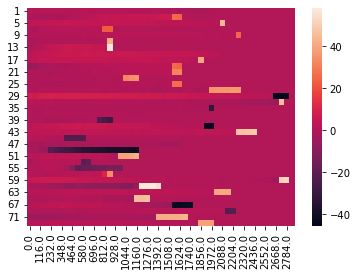

In [33]:
sns.heatmap(q)

In [19]:
dfb2

,0.0,29.0,58.0,87.0,116.0,145.0,174.0,203.0,232.0,261.0,...,2610.0,2639.0,2668.0,2697.0,2726.0,2755.0,2784.0,2813.0,2842.0,2871.0
1,7.083873,9.821601,11.031815,12.078756,13.623327,14.652439,15.766570,16.268180,17.226501,17.603035,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,4.257131,5.305040,6.379740,8.142910,9.659735,10.993762,12.449429,13.955789,15.241087,16.664047,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
5,8.251761,11.683469,13.460263,15.716077,17.220318,19.199994,20.848562,21.870856,23.196060,24.195631,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
7,8.208847,8.620262,9.031678,12.163070,13.373012,14.586430,15.556537,16.238929,18.181741,18.351988,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
9,4.955401,6.489406,7.493702,8.782782,9.941057,10.854754,11.626641,12.297561,13.356611,13.894102,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
11,12.074462,14.025995,16.294984,18.007225,19.971902,21.514006,22.896846,23.975525,25.434708,26.433424,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
13,21.884775,25.684505,30.839121,32.794330,35.283183,38.047455,40.553030,42.245741,43.796430,45.469303,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
15,12.708218,13.682667,17.595678,19.275374,21.209007,22.904091,24.021919,25.407206,26.725663,27.480666,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
17,9.231107,11.736501,14.483201,15.930028,16.948101,18.196357,19.311808,20.142088,20.910002,21.881844,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
19,0.000000,0.000000,0.000000,3.440734,6.706678,7.950694,9.528459,10.819518,11.851919,12.477710,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [9]:
df_measurements.normed_current.max()

    if norm:
        col_name = "normed_current"
    else:
        col_name = "current"
        
    if max_current == None:
        max_current = sf_ceil(df_measurements[col_name].max(), 2)
        
    bins = np.histogram_bin_edges([], bins=num_bins, range=(0, max_current))
    df_binned = pd.DataFrame(columns=list(range(1, num_bins+1)))
    
    for cell_no, group in df_measurements.groupby("cell"):
        group["bin"] = np.digitize(group[col_name], bins)
        binned_data = {}
        for bin_num, g in group.groupby("bin"):
            binned_data[bin_num] = [g["frequency"].mean()]

        current_cell = pd.DataFrame(binned_data)
        current_cell.index=[cell_no]

        df_binned = pd.concat([df_binned, current_cell])

    df_binned = df_binned.astype(float).interpolate(method="slinear", axis=1).fillna(0)
    df_binned.columns = bins[:-1]
    
    return df_binned

4156.69990234375

In [79]:
def sf_round(x, sf=1):
	power = 10**np.floor(np.log10(abs(x)))
	power *= 10**(1-sf)
	output = round(x/power)*power
	if power >= 0:
		return int(output)
	else:
		return output

In [82]:
sf_round(1.3456, 2)

1

In [92]:
x1 = 0.2345
p = abs(x1)
p = np.log10(p)
p = np.floor(p)
p = p + 1-2
p = 10**p
round(x1/p)*p

0.23